**PM Lipidomics By Subclass**

In [1]:
# load packages
library(ggplot2)
library(ggsignif)
library(SingleCellExperiment)

Warning message:
“package ‘ggplot2’ was built under R version 3.6.3”Warning message:
“package ‘ggsignif’ was built under R version 3.6.3”Loading required package: SummarizedExperiment
Loading required package: GenomicRanges
Loading required package: stats4
Loading required package: BiocGenerics
Loading required package: parallel

Attaching package: ‘BiocGenerics’

The following objects are masked from ‘package:parallel’:

    clusterApply, clusterApplyLB, clusterCall, clusterEvalQ,
    clusterExport, clusterMap, parApply, parCapply, parLapply,
    parLapplyLB, parRapply, parSapply, parSapplyLB

The following objects are masked from ‘package:stats’:

    IQR, mad, sd, var, xtabs

The following objects are masked from ‘package:base’:

    anyDuplicated, append, as.data.frame, basename, cbind, colnames,
    dirname, do.call, duplicated, eval, evalq, Filter, Find, get, grep,
    grepl, intersect, is.unsorted, lapply, Map, mapply, match, mget,
    order, paste, pmax, pmax.int, pmin, pmin.in

In [2]:
# load PM lipidomic data
data = readRDS('../../ABCA7lof//processed_data/for_plotting/lipidomics.rds')
d = data$pm_all
cts = assays(d)$counts
class = rowData(d)$lipid.class
cts$class = class

# sum lipidomic data by class
result <- aggregate(. ~ class, data = cts[cts$class %in% unique(class), ], sum)
rownames(result) = result$class
result$class = NULL
df =  as.data.frame(t(result))
total = rowSums(df)
genotype = colData(d)$LOF_status
df = as.data.frame(cbind(df, genotype, total))

In [3]:
head(df)

,AcCa,AcHexChE,AEA,CarE,Cer,CerG3GNAc1,ChE,CL,Co,cPA,⋯,SPH,SPHP,SQDG,ST,StE,TG,WE,ZyE,genotype,total
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>,<dbl>
1A,6.2300e+10,3e+08,9.10e+09,7.0e+07,386842200000,8.56e+09,4.0020e+11,3.52151e+11,1.2e+10,2e+08,⋯,8.100e+09,0e+00,4.401e+09,1.0e+08,5e+08,87894000000,5.650e+10,4.4900e+10,CON,1.250676e+13
5C,3.1270e+10,4e+07,6.07e+09,1.0e+08,228500000000,7.30e+09,4.1020e+11,5.36492e+11,5.7e+10,2e+08,⋯,5.080e+09,7e+06,8.740e+08,2.4e+08,2e+08,682171000000,1.200e+08,1.3900e+10,CON,1.211328e+13
7D,3.6670e+10,5e+07,9.90e+09,1.0e+08,302010000000,6.30e+09,4.2890e+11,5.38716e+11,6.9e+10,2e+08,⋯,8.300e+09,0e+00,1.730e+09,6.0e+08,1e+08,411700600000,1.615e+10,1.2820e+10,CON,1.222214e+13
9E,5.5391e+10,1e+08,7.70e+09,3.6e+08,468780000000,6.69e+09,5.0900e+11,5.44110e+11,6.8e+10,5e+08,⋯,6.720e+09,9e+07,2.170e+09,4.0e+08,2e+08,314180000000,1.540e+10,1.2110e+10,CON,1.285725e+13
13G,4.6470e+10,8e+07,6.41e+09,2.5e+08,372950000000,4.40e+09,5.0240e+11,5.61390e+11,7.6e+10,1e+08,⋯,5.150e+09,0e+00,1.267e+09,2.0e+08,5e+08,519490000000,8.000e+08,1.1200e+10,CON,1.309803e+13
19J,7.4652e+10,1e+08,8.53e+09,6.0e+08,381990000000,4.30e+09,5.0834e+11,4.73250e+11,5.2e+10,8e+08,⋯,6.476e+09,2e+06,2.070e+09,2.0e+08,2e+08,328610000000,1.608e+10,1.6104e+10,CON,1.212852e+13


In [26]:
# Plot ratios

## PC/total
options(repr.plot.width = 2.5, repr.plot.height = 3)

pdf('../pdf_figures/pm_PC_total.pdf', width=2.5, height=3)
ggplot(df, aes(x = genotype, y = PC/total)) +
  geom_boxplot(outlier.shape = 1) +
  labs(x = "Genotype", y = "PC/total", title = "") +
  theme_minimal() + geom_signif(comparisons = list(c("CON", "LOF")), textsize = 5, test = "t.test", map_signif_level = F) #+ ylim(c(0,1.5e+13))
dev.off()

## TG/total
options(repr.plot.width = 2.5, repr.plot.height = 3)

pdf('../pdf_figures/pm_TG_total.pdf', width=2.5, height=3)
ggplot(df, aes(x = genotype, y = TG/total)) +
  geom_boxplot(outlier.shape = 1) +
  labs(x = "Genotype", y = "TG/total", title = "") +
  theme_minimal() + geom_signif(comparisons = list(c("CON", "LOF")), textsize = 5, test = "t.test", map_signif_level = F) #+ ylim(c(0,1.5e+13))
dev.off()

## PC/TG
options(repr.plot.width = 2.5, repr.plot.height = 3)

pdf('../pdf_figures/pm_pc_to_tg.pdf', width=2.5, height=3)
ggplot(df, aes(x = genotype, y = PC/TG)) +
  geom_boxplot(outlier.shape = 1) +
  labs(x = "Genotype", y = "PC:TG", title = "") +
  theme_minimal() +   geom_jitter(width=.1) + geom_signif(comparisons = list(c("CON", "LOF")), textsize = 5, test = "t.test", map_signif_level = F) #+ ylim(c(0,1.5e+13))
dev.off()

png 
  2

In [221]:
## Volcano plot
plot_volcano = function(sce, ratio_name, pval_name, pval_cut, lfc_cut, adjust, annotation1, class_cols){
    cols = c('dodgerblue2', 'grey', 'red')
    names(cols) = c('down', 'other', 'up')
    temp = as.data.frame(rowData(sce)[,c(ratio_name, pval_name, annotation1)])
    colnames(temp) = c('log2', 'pvalue', 'label')
    if(adjust){
        temp$pvalue = p.adjust(temp$pvalue, 'fdr')
    }
    temp$direction = ifelse(temp$log2>lfc_cut & temp$pvalue<pval_cut, 'up', ifelse(temp$log2< -1*lfc_cut & temp$pvalue<pval_cut, 'down', 'other'))
    temp$label2 = ifelse(temp$direction!='other', temp$label,'')
    p = ggplot(temp, aes(x=log2, y= -log10(pvalue), col=direction, label = label2))+ geom_text_repel(max.overlaps = Inf, size = 3.5)+  scale_color_manual(values = cols) + geom_point(aes(alpha = 0.01), size = 2, show.legend = FALSE)+theme_classic() +   theme(text = element_text(size=10),strip.background = element_blank(),strip.placement = "outside" ,strip.text.y = element_text(size = 10, color = "black"))+ theme(legend.position='none')#+ #facet_wrap(~label, ncol = 7, scales = "free_x")
    return(p+xlab('log2(fold change)')+ylab('-log10(p-value)'))
}

options(repr.plot.width = 5, repr.plot.height = 4)

# show the top lipid species
library(ggrepel)

pdf('../pdf_figures/pm_volcano.pdf', width=5, height=4)
plot_volcano(data$pm_all, 'stats.log2', 'stats.pvalue',  0.1, 1, FALSE, 'lipid.key', c('brown1'))+xlim(c(-4,4))
dev.off()

**NGN2 Lipidomics By Subclass**

In [2]:
# load the iN lipidomics data
data = readRDS('../../ABCA7lof//processed_data/for_plotting/lipidomics.rds')
d = data$ngn2_all
cts = assays(d)$counts
class = rowData(d)$lipid.class
cts$class = class

# sum by lipid class
result <- aggregate(. ~ class, data = cts[cts$class %in% unique(class), ], sum)
rownames(result) = result$class
result$class = NULL
df =  as.data.frame(t(result))
total = rowSums(df)
df = as.data.frame(cbind(df, colData(d)[,c('Genotype', 'treatment', 'Cell counts')], total))

df2 = df[df$treatment!='Choline',]
df2$grp = paste0(df2$Genotype, df2$treatment)
df2$Genotype = factor(df2$Genotype, levels = c('Control', 'ABCA7 LoF'))

# load key info
data = readRDS('../../ABCA7lof//processed_data/for_plotting/lipidomics.rds')
key = read.csv('../../ABCA7lof//raw_data/ngn2_data/lipidkey.csv', sep = '\t')
key = key[!duplicated(key$Key),]
rownames(key) = key$Key
rowData(data$ngn2_all)$Class = as.character(key[rowData(data$ngn2_all)$lipid.class,'Class'])

In [679]:
# plot volcano for subclasses

plot_volcano = function(sce, ratio_name, pval_name, pval_cut, lfc_cut, adjust, annotation1, cols){
    temp = as.data.frame(rowData(sce)[,c(ratio_name, pval_name, annotation1)])
    colnames(temp) = c('log2', 'pvalue', 'label')
    if(adjust){
        temp$pvalue = p.adjust(temp$pvalue, 'fdr')
    }
    temp$direction = ifelse(temp$log2>lfc_cut & temp$pvalue<pval_cut, 'up', ifelse(temp$log2< -1*lfc_cut & temp$pvalue<pval_cut, 'down', 'other'))
    labs = temp$label[temp$direction!='other']
    temp$label2 = ifelse(temp$label%in%labs, temp$label, 'other')#temp$direction!='other' | temp$, temp$label,'other')
    temp$rank = rank(temp$log2)
    temp = temp[temp$label2!='other',]
    p = ggplot(temp, aes(x=log2, y=-log10(pvalue), col=label2))+   scale_color_manual(values = cols) +  geom_point(aes(alpha = ifelse(temp$direction!='other', .4, 0)), size=2) + geom_point(aes(alpha = 1),shape=21,stroke=ifelse(temp$direction=='other', 0, .6), size = 2, show.legend = TRUE)+theme_classic() +   theme(text = element_text(size=10),strip.background = element_blank(),strip.placement = "outside" ,strip.text.y = element_text(size = 10, color = "black"))+ theme(legend.position='right')#+facet_grid(label2 ~ . , scales="free", space="free")
#+ #facet_wrap(~label, ncol = 7, scales = "free_x")
    return(p+xlab('log2(fold change)')+ylab('-log10(p-value)'))
}

cols = pal_npg("nrc")(10)
names(cols) = c('DG', 'Cer', 'CL', 'Hex1Cer', 'MG', 'MLCL', 'PC', 'PG', 'PS', 'other')
cols['other'] = 'lightgrey'

cols = c('gold', 'red', 'purple', 'green', 'black')
names(cols) = unique(rowData(data$ngn2_all)$Class)

options(repr.plot.width =7, repr.plot.height = 4)

#pdf('../pdf_figures/major_class_lipid_in.pdf', width=7, height=4)
plot_volcano(data$ngn2_all, 'logfc_both_batch', 'pvals_both_batch',  0.005, 0, FALSE, 'Class', cols) + xlim(-5,5) + geom_hline(yintercept=-log10(0.005),  linetype='dashed')+ geom_vline(xintercept=0, linetype='dashed')
#dev.off()

Warning message:
“Use of `temp$direction` is discouraged. Use `direction` instead.”Warning message:
“Removed 8 rows containing missing values (geom_point).”Warning message:
“Removed 8 rows containing missing values (geom_point).”

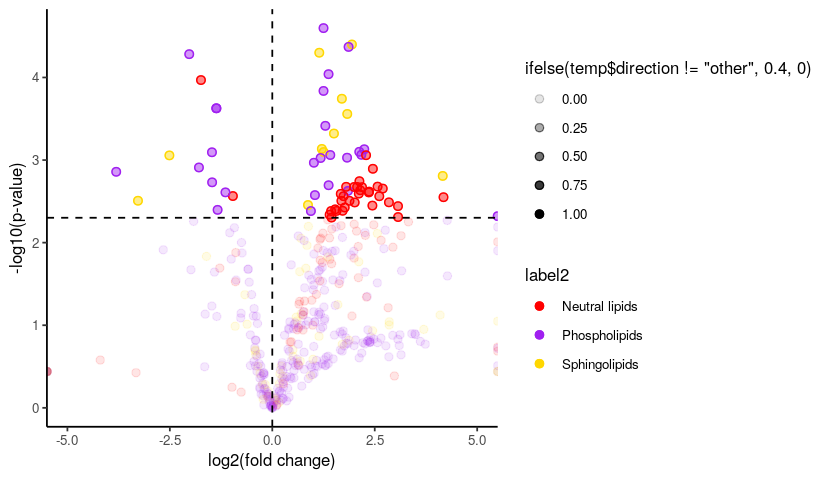

In [10]:
## Plot ratios
library(reshape2)

T = df[, 1:31]/df$total
T$Genotype = df$Genotype
T[,'PC:TG'] = T$PC/T$TG
T[,'CL:TG'] = T$CL/T$TG

T[,'MG:TG'] = T$MG/T$TG
T[,'LPC:PC'] = T$LPC/T$PC

### Nr 1

x = melt(T)
x = x[as.character(x$variable)%in%c('DG', 'PC', 'TG'),]

options(repr.plot.width = 10, repr.plot.height = 2.5)

cols = c('grey', 'blue')
names(cols) = c('Control', 'ABCA7 LoF')
x$Genotype = factor(x$Genotype, levels=c('Control', 'ABCA7 LoF'))

pdf('../pdf_figures/ratios_iN3.pdf', width=5, height = 2.5)
ggplot(x, aes(x = Genotype, y = value)) +
  geom_boxplot(aes(color=Genotype, fill=Genotype, alpha=.5)) +
  labs(x = "", y = "sum subclass/total", title = "") +
  theme_classic() + geom_jitter(aes(color=Genotype), width=.1) + scale_y_continuous(limits = c(0, NA)) + geom_signif(comparisons = list(c("Control", "ABCA7 LoF")), textsize = 3, test = "t.test", map_signif_level = F) + scale_fill_manual(values = cols)  + scale_color_manual(values = cols) + facet_wrap(~variable, nrow=1, scales = "free") +   theme(
    axis.text.x = element_blank(),  # Remove x-axis labels
    axis.ticks.x = element_blank() , strip.background = element_rect(fill = "white", color = NA)) + coord_cartesian(clip = "off")
dev.off()
# Remove x-axis ticks

#+ ylim(c(0,1.5e+13))

### Nr 2 

x = melt(T)
x = x[as.character(x$variable)%in%c('PC:TG', 'MG:TG', 'LPC:PC'),]

options(repr.plot.width = 5, repr.plot.height = 2.5)

cols = c('grey', 'blue')
names(cols) = c('Control', 'ABCA7 LoF')
x$Genotype = factor(x$Genotype, levels=c('Control', 'ABCA7 LoF'))
pdf('../pdf_figures/ratios2_iN.pdf', width=5, height = 2.5)

ggplot(x, aes(x = Genotype, y = value)) +
  geom_boxplot(aes(color=Genotype, fill=Genotype, alpha=.5)) +
  labs(x = "", y = "Ratio subclass # 1 / subclass #2", title = "") +
  theme_classic() + geom_jitter(aes(color=Genotype), width=.1) + scale_y_continuous(limits = c(0, NA)) + geom_signif(comparisons = list(c("Control", "ABCA7 LoF")), textsize = 3, test = "t.test", map_signif_level = F) + scale_fill_manual(values = cols)  + scale_color_manual(values = cols) + facet_wrap(~variable, nrow=1, scales = "free") +   theme(
    axis.text.x = element_blank(),  # Remove x-axis labels
    axis.ticks.x = element_blank() , strip.background = element_rect(fill = "white", color = NA)) 

dev.off()
# Remove x-axis ticks
#+ ylim(c(0,1.5e+13))

Warning message:
“Following annotation names are duplicated: foo, label”Warning message in grid.Call.graphics(C_rect, x$x, x$y, x$width, x$height, resolveHJust(x$just, :
“supplied color is neither numeric nor character”Warning message in grid.Call.graphics(C_rect, x$x, x$y, x$width, x$height, resolveHJust(x$just, :
“supplied color is neither numeric nor character”

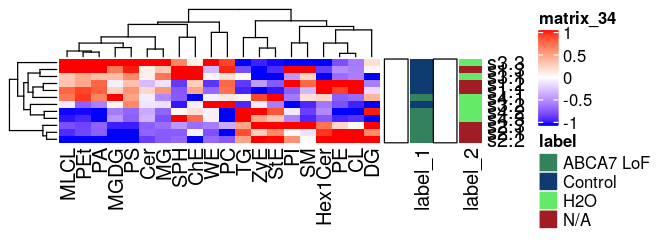

In [173]:
### Plot heatmap - main classes 

options(repr.plot.width = 5.5, repr.plot.height = 2)

df2 = df2[df2$treatment!='Choline',]

category_colors <- list('Control' = "blue", 'ABCA7 LoF' = "red")

row_annotation <- rowAnnotation(foo = anno_block(gp = gpar(fill = category_colors[as.character(df2$Genotype)])), label=as.character(df2$Genotype))

category_colors <- list('N/A' = "blue", 'H2O' = "blue", "Choline" = 'red')
row_annotation2 <- rowAnnotation(foo = anno_block(gp = gpar(fill = category_colors[as.character(df2$treatment)])), label=as.character(df2$treatment))

library(ComplexHeatmap)
library(circlize)
temp = df2[,1:31]/df2$total

Heatmap((scale((temp[,colMeans(temp)>0.001]
))),right_annotation = c(row_annotation, row_annotation2),        col = colorRamp2(c(-1, 0, 1), c("blue", "white", "red")))